# **OVERVIEW OF THE DATASET**

- Definition of sleep event: 
    - Event class: Onset/Wakeup
    - Sleep Onset is indicate the beginning of the sleep, and wakeup is defined as the ebd of the sleep.
    - Single sleep period must be the longest inactive period while the accelerometer is worn. 
    - Single sleep must be the at leat 30 minutes in length which can be interrupted by bouts that do not exceed 30 consecutive 30 mm,inutes.
    
    
- The individual can have multiple sleep window in same clander day. But the **longest sleep window during the night will be recored**.


- There is no strict rule to limit number of sleep events in a givien period **however only one window assign per nigth**.


- The event that annotated when the accelerometer removed should be refrain from makking predictions. 

- **Target variable: Event (Oneset/Wakeup)**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import polars as pl
import datetime as dt

- Since the dataset is quite big, Used polars to load fast and effectively in memory.
- Converted the outpiut into pandas dataframe to perform EDA and analysis.

In [2]:
# reading train_series parquet file as well as converting the timestamp to datetime dtype
train_series = (pl.scan_parquet("/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet")
    .with_columns(pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z"))
    .collect().to_pandas())

# reading train_event csv
train_event = (pl.scan_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
              .with_columns(pl.col('timestamp').str.strptime(pl.Datetime,"%Y-%m-%dT%H:%M:%S%Z"))
              .collect().to_pandas())

In [3]:
# understanding the features 
train_series.info()
print(f"\n The shape of the Dataset is : \n rows = {train_series.shape[0]}, columns = {train_series.shape[1]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946340 entries, 0 to 127946339
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   series_id  object        
 1   step       uint32        
 2   timestamp  datetime64[ns]
 3   anglez     float32       
 4   enmo       float32       
dtypes: datetime64[ns](1), float32(2), object(1), uint32(1)
memory usage: 3.3+ GB

 The shape of the Dataset is : 
 rows = 127946340, columns = 5


In [4]:
# understanding the features 
train_event.info()
print(f"\n The shape of the Dataset is : \n rows = {train_event.shape[0]}, columns = {train_event.shape[1]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   series_id  14508 non-null  object        
 1   night      14508 non-null  int64         
 2   event      14508 non-null  object        
 3   step       9585 non-null   float64       
 4   timestamp  9585 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 566.8+ KB

 The shape of the Dataset is : 
 rows = 14508, columns = 5


# Getting insight from Train_series

In [5]:
# display the top 5 rows
train_series.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14 15:30:00,2.6367,0.0217
1,038441c925bb,1,2018-08-14 15:30:05,2.6368,0.0215
2,038441c925bb,2,2018-08-14 15:30:10,2.6370,0.0216
3,038441c925bb,3,2018-08-14 15:30:15,2.6368,0.0213
4,038441c925bb,4,2018-08-14 15:30:20,2.6368,0.0215


In [6]:
# Total unique series_id
train_series['series_id'].nunique()

277

In [7]:
# Five point summary
train_series.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
series_id,127946340,277,78569a801a38,1433880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
step,127946340.0,NaN,NaN,NaN,254804.797188,0.0,115812.0,234519.0,357196.0,1433879.0,177892.965593
timestamp,127946340,NaN,NaN,NaN,2018-07-16 13:31:51.766071296,2017-08-04 17:30:00,2018-02-12 20:09:30,2018-07-22 02:40:47.500000,2018-12-24 18:28:05,2019-07-09 09:44:55,NaN
anglez,127946340.0,NaN,NaN,NaN,-8.810453,-90.0,-31.8589,-9.5979,11.3002,90.0,35.521877
enmo,127946340.0,NaN,NaN,NaN,0.041315,0.0,0.0013,0.0172,0.0437,11.4337,0.101829


In [8]:
# null value check
train_series.isnull().sum()

series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64

# Initial observation - Train_series
- There are 277 accelerometer series_id.
- The step is unique identifier of the observation.
- The anglez value range from -90 to +90 which is **inline with the angle of the arm relative to the vertical axis of the body.** (complete 180 degree angle)
- There are no null values in the train_series.

# Getting insight from Train_event

In [9]:
# display tpo 5 rows
train_event.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00


In [10]:
# Five point summary
train_event.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
series_id,14508,277,78569a801a38,168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
night,14508.0,NaN,NaN,NaN,15.120072,1.0,7.0,14.0,21.0,84.0,10.286758
event,14508,2,onset,7254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
step,9585.0,NaN,NaN,NaN,214352.123944,936.0,95436.0,200604.0,317520.0,739392.0,141268.408192
timestamp,9585,NaN,NaN,NaN,2018-07-01 05:31:32.450704128,2017-08-05 22:44:00,2018-01-25 22:09:00,2018-06-16 23:05:00,2018-12-17 06:36:00,2019-07-05 05:33:00,NaN


In [11]:
# check for null values
train_event.isnull().sum()

series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64

In [12]:
train_event[train_event['step'].isnull()]

,series_id,night,event,step,timestamp
8,038441c925bb,5,onset,NaN,NaT
9,038441c925bb,5,wakeup,NaN,NaT
16,038441c925bb,9,onset,NaN,NaT
17,038441c925bb,9,wakeup,NaN,NaT
26,038441c925bb,14,onset,NaN,NaT
...,...,...,...,...,...
14437,fcca183903b7,36,wakeup,NaN,NaT
14438,fe90110788d2,1,onset,NaN,NaT
14439,fe90110788d2,1,wakeup,NaN,NaT
14506,fe90110788d2,35,onset,NaN,NaT


In [13]:
train_series[train_series['series_id'] == '038441c925bb']

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14 15:30:00,2.636700,0.0217
1,038441c925bb,1,2018-08-14 15:30:05,2.636800,0.0215
2,038441c925bb,2,2018-08-14 15:30:10,2.637000,0.0216
3,038441c925bb,3,2018-08-14 15:30:15,2.636800,0.0213
4,038441c925bb,4,2018-08-14 15:30:20,2.636800,0.0215
...,...,...,...,...,...
389875,038441c925bb,389875,2018-09-06 04:59:35,-27.373899,0.0110
389876,038441c925bb,389876,2018-09-06 04:59:40,-27.493799,0.0110
389877,038441c925bb,389877,2018-09-06 04:59:45,-27.533701,0.0111
389878,038441c925bb,389878,2018-09-06 04:59:50,-28.003599,0.0111


In [14]:
train_event[train_event['series_id'] == '038441c925bb']

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00
5,038441c925bb,3,wakeup,44400.0,2018-08-17 05:10:00
6,038441c925bb,4,onset,57240.0,2018-08-17 23:00:00
7,038441c925bb,4,wakeup,62856.0,2018-08-18 06:48:00
8,038441c925bb,5,onset,NaN,NaT
9,038441c925bb,5,wakeup,NaN,NaT


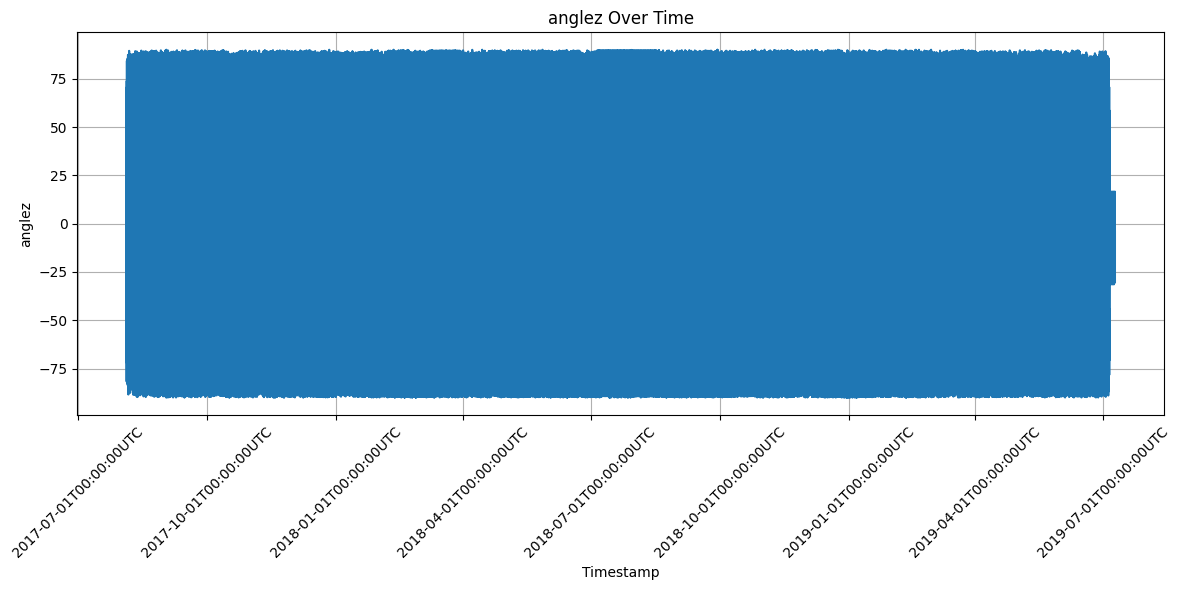

In [15]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(train_series['timestamp'], train_series['anglez'], linestyle='-')

# Set plot labels and title
plt.xlabel('Timestamp')
plt.ylabel('anglez')
plt.title('anglez Over Time')

# set additional formatting for the x-axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%dT%H:%M:%S%Z"))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)  
plt.tight_layout() 
plt.show()

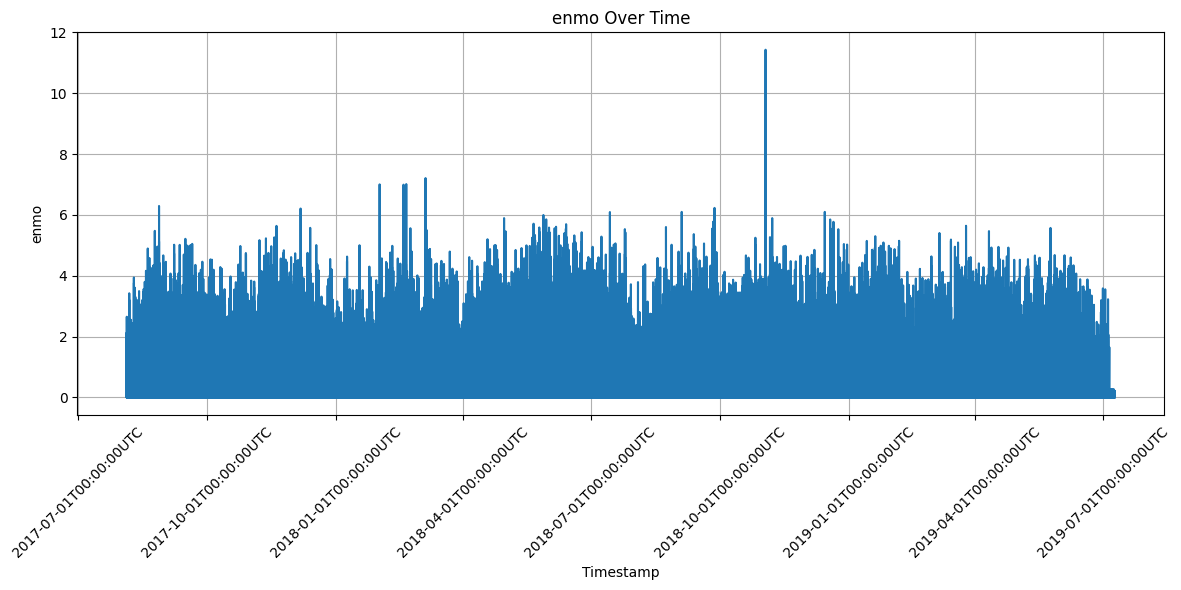

In [16]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(train_series['timestamp'], train_series['enmo'], linestyle='-')

# Set plot labels and title
plt.xlabel('Timestamp')
plt.ylabel('enmo')
plt.title('enmo Over Time')

# set additional formatting for the x-axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%dT%H:%M:%S%Z"))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)  
plt.tight_layout() 
plt.show()